In [344]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
%matplotlib inline
import nltk
nltk.download('stopwords')
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranavipanduga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# DATA PRE-PROCESSING

In [345]:
news = pd.read_csv('news 2.csv')

In [346]:
news.shape

(6335, 4)

In [347]:
news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [348]:
news['label'] = news['label'].replace(['FAKE', 'REAL'],[1, 0])

In [349]:
news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [350]:
news.describe()

,Unnamed: 0,label
count,6335.000000,6335.000000
mean,5280.415627,0.499448
std,3038.503953,0.500039
min,2.000000,0.000000
25%,2674.500000,0.000000
50%,5271.000000,0.000000
75%,7901.000000,1.000000
max,10557.000000,1.000000


In [351]:
news.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

# DATA PROCESSING

In [352]:
stem = PorterStemmer()

In [353]:
def stemming (content):
    stemmed_content = re.sub('[^a-zA-Z]',' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [stem.stem(word) for word in stemmed_content if not word in stopwords.words ('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content
news['title'] = news['title'].apply(stemming)

In [359]:
def process_text(s):
    nopunc = [char for char in s if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    clean_string = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return clean_string
news['Clean Text'] = news['text'].apply(process_text)

In [361]:
news = news.apply(lambda x: x.astype(str).str.lower())

In [362]:
news['text'] = news['text'].str.replace('[^\w\s,]', '')
news['text'] = news['text'].str.replace('http\S+|www.\S+', '', case=False)
news['text'] = news['text'].str.replace(' ,', ',')
news['text'] = news['text'].str.replace(', ', ',')

/var/folders/gg/rb93zdc963qdht_9s178ppm80000gn/T/ipykernel_35736/1089151858.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  news['text'] = news['text'].str.replace('[^\w\s,]', '')
/var/folders/gg/rb93zdc963qdht_9s178ppm80000gn/T/ipykernel_35736/1089151858.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  news['text'] = news['text'].str.replace('http\S+|www.\S+', '', case=False)


In [363]:
tokenizer = RegexpTokenizer(r'\w+')
news['text'] = news['text'].apply(lambda x: tokenizer.tokenize(x))

In [364]:
print(news.head())

  Unnamed: 0                                              title  \
0       8476                                 smell hillari fear   
1      10294  watch exact moment paul ryan commit polit suic...   
2       3608                      kerri go pari gestur sympathi   
3      10142     berni support twitter erupt anger dnc tri warn   
4        875                      battl new york primari matter   

                                                text label  \
0  [daniel, greenfield, a, shillman, journalism, ...     1   
1  [google, pinterest, digg, linkedin, reddit, st...     1   
2  [us, secretary, of, state, john, f, kerry, sai...     0   
3  [kaydee, king, kaydeeking, november, 9, 2016, ...     1   
4  [its, primary, day, in, new, york, and, frontr...     0   

                                          Clean Text  
0  ['danielgreenfieldashillmanjournalismfellowatt...  
1  ['googlepinterestdigglinkedinredditstumbleupon...  
2  ['ussecretaryofstatejohnfkerrysaidmondaythathe...  
3  [

In [365]:
vectorizer1 = TfidfVectorizer(max_features=2000)
vectorizer1.fit(news['text'])
vectorizedtfidf = vectorizer1.transform(news['text'])

vectorizer2 = CountVectorizer(max_features=2000)
vectorizer2.fit(news['text'])
vectorizedbow = vectorizer2.transform(news['text'])

print("Shape of the TF-IDF vector: ", vectorizedtfidf.shape)
print("Shape of the BOW vector: ", vectorizedbow.shape)

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
label = news['label'].values
label = label.reshape(-1, 1)
news.sample(5)

# Exploratory Data Analysis

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
vectorizedtfidf_tsne_copy= vectorizedtfidf.copy()
vectorizedtfidf_tsne_copy = tsne.fit_transform(vectorizedtfidf_tsne_copy.toarray())
plt.figure(figsize=(5, 3))
sns.scatterplot(x=vectorizedtfidf_tsne_copy[:,0], y=vectorizedtfidf_tsne_copy[:,1], hue=news['label'])
plt.title('TSNE on TF-IDF Vector')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
vectorizedbow_tsne_copy= vectorizedbow.copy()
vectorizedbow_tsne_copy = tsne.fit_transform(vectorizedbow_tsne_copy.toarray())
plt.figure(figsize=(10, 7))
sns.scatterplot(x=vectorizedbow_tsne_copy[:,0], y=vectorizedbow_tsne_copy[:,1], hue=news['label'])
plt.title('TSNE on BoW Vector')
plt.show()

# TRAINING DATA

In [ ]:
vectorizedtfidf = vectorizedtfidf.toarray()
vectorizedbow = vectorizedbow.toarray()

In [366]:
label = news['label'].values
print(label)
print(vectorizedbow)

['1' '1' '0' ... '1' '0' '0']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [367]:
label_reshaped = label.reshape(-1, 1)
vectorizedtfidfr = vectorizedtfidf.reshape(-1, 1)

news1 = np.concatenate((vectorizedtfidf, label_reshaped), axis=1)
news2 = np.concatenate((vectorizedbow, label_reshaped), axis=1)

news1_df = pd.DataFrame(news1, columns=[f"feature_{i}" for i in range(news1.shape[1]-1)]+["label"])
news2_df = pd.DataFrame(news2, columns=[f"feature_{i}" for i in range(news2.shape[1]-1)]+["label"])

print(news1_df.head())

  feature_0 feature_1 feature_2 feature_3 feature_4 feature_5 feature_6  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3  0.040459       0.0       0.0  0.049305       0.0       0.0       0.0   
4       0.0  0.043736       0.0       0.0       0.0       0.0       0.0   

  feature_7 feature_8 feature_9  ... feature_1991 feature_1992 feature_1993  \
0       0.0       0.0       0.0  ...     0.026445      0.04139          0.0   
1       0.0       0.0       0.0  ...          0.0          0.0          0.0   
2       0.0       0.0       0.0  ...          0.0          0.0          0.0   
3  0.048905       0.0       0.0  ...     0.040959          0.0          0.0   
4       0.0       0.0       0.0  ...     0.209922     0.026284     0.050749   

  feature_1994 feature_1995 feature_1996 feature_1997 feature_1998  \
0   

In [368]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(news1[:, :-1], news1[:, -1], test_size=0.2, random_state=0)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_test1, y_test1, test_size=0.5, random_state=0)

X_train2, X_test2, y_train2, y_test2 = train_test_split(news2[:, :-1], news2[:, -1], test_size=0.2, random_state=0)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_test2, y_test2, test_size=0.5, random_state=0)

# MODELS: logistic regression, naive bayes, decision tree classifier

LOGISTIC REGRESSION

tf-idf

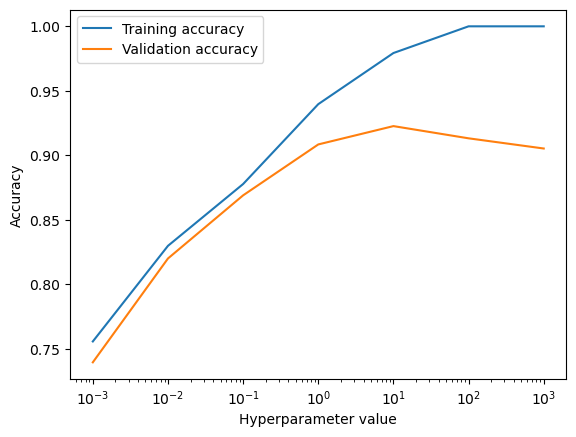

Test accuracy: 0.923


In [369]:
hyperparams = np.logspace(-3, 3, 7)

train_accs = []
val_accs = []
for hyperparam in hyperparams:
    model = LogisticRegression(C=hyperparam, solver='lbfgs', max_iter=1000, random_state=42)
    model.fit(X_train1, y_train1)
    train_acc = model.score(X_train1, y_train1)
    val_acc = model.score(X_val1, y_val1)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

plt.plot(hyperparams, train_accs, label='Training accuracy')
plt.plot(hyperparams, val_accs, label='Validation accuracy')
plt.xscale('log')
plt.xlabel('Hyperparameter value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

best_hyperparam = hyperparams[np.argmax(val_accs)]

final_model = LogisticRegression(C=best_hyperparam, solver='lbfgs', max_iter=1000, random_state=42)
final_model.fit(X_train1, y_train1)
test_acc = final_model.score(X_test1, y_test1)
print(f'Test accuracy: {test_acc:.3f}')

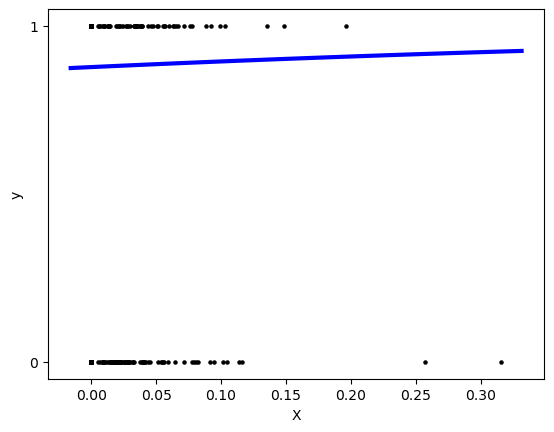

In [370]:
plt.figure()
plt.scatter(X_test1[:, 0], y_test1, color='black', s=20, marker='.')
xmin, xmax = plt.xlim()
coef = final_model.coef_[0]
intercept = final_model.intercept_
x_line = np.linspace(xmin, xmax, num=100)
y_line = 1 / (1 + np.exp(-(coef[0] * x_line + intercept)))
plt.plot(x_line, y_line, color='blue', linewidth=3)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

bow

/Users/pranavipanduga/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pranavipanduga/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

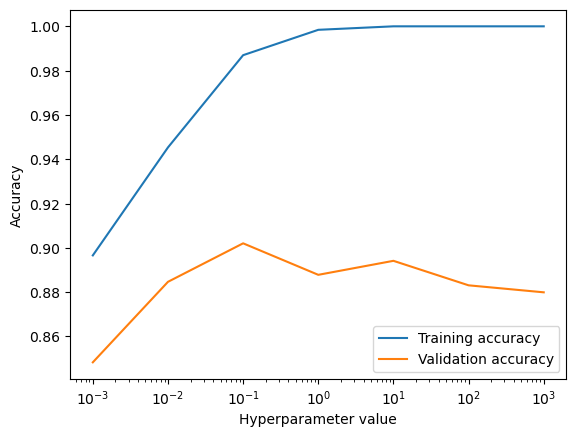

Test accuracy: 0.896


In [371]:
hyperparams = np.logspace(-3, 3, 7)

train_accs = []
val_accs = []
for hyperparam in hyperparams:
    model = LogisticRegression(C=hyperparam, solver='lbfgs', max_iter=1000, random_state=42)
    model.fit(X_train2, y_train2)
    train_acc = model.score(X_train2, y_train2)
    val_acc = model.score(X_val2, y_val2)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

plt.plot(hyperparams, train_accs, label='Training accuracy')
plt.plot(hyperparams, val_accs, label='Validation accuracy')
plt.xscale('log')
plt.xlabel('Hyperparameter value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

best_hyperparam = hyperparams[np.argmax(val_accs)]

final_model = LogisticRegression(C=best_hyperparam, solver='lbfgs', max_iter=1000, random_state=42)
final_model.fit(X_train2, y_train2)
test_acc = final_model.score(X_test2, y_test2)
print(f'Test accuracy: {test_acc:.3f}')

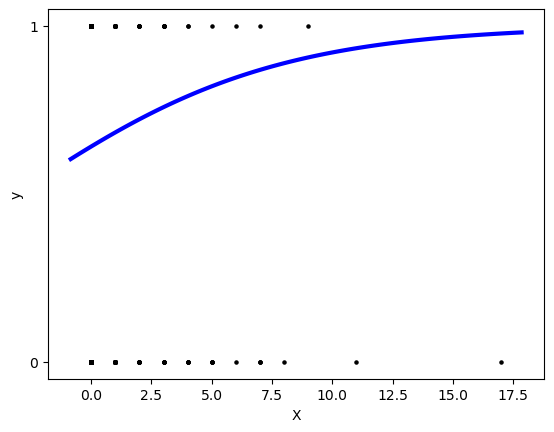

In [372]:
plt.figure()
plt.scatter(X_test2[:, 0], y_test2, color='black', s=20, marker='.')
xmin, xmax = plt.xlim()
coef = final_model.coef_[0]
intercept = final_model.intercept_
x_line = np.linspace(xmin, xmax, num=100)
y_line = 1 / (1 + np.exp(-(coef[0] * x_line + intercept)))
plt.plot(x_line, y_line, color='blue', linewidth=3)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

NAIVE BAYES: MULTINOMIAL

In [374]:
def mnblearn(X_train,y_train,X_val,y_val):
    mnb=MultinomialNB()
    param_grid = {'var_smoothing': np.logspace(0,-9, num=10)}
    grid_search = GridSearchCV(gnb, param_grid, cv=3,refit=True,n_jobs=-1,scoring='accuracy',verbose=1)
    grid_search.fit(X_train,y_train)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    print("Accuracy: ",accuracy_score(y_val,grid_search.predict(X_val)))
    print(classification_report(y_val,grid_search.predict(X_val)))
    train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1, verbose=1,shuffle=True)
    train_mean=np.mean(train_scores,axis=1)
    train_std=np.std(train_scores,axis=1)
    test_mean=np.mean(test_scores,axis=1)
    test_std=np.std(test_scores,axis=1)
    plt.plot(train_sizes,train_mean,color='blue',marker='o',label='training accuracy')
    plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
    plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',label='validation accuracy')
    plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')
    plt.title("Learning Curve for Multinomial Naive Bayes")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc='best')
    plt.show()

tf-idf

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'var_smoothing': 0.001}
0.8494469960517234
Accuracy:  0.8388625592417062
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       334
           1       0.83      0.83      0.83       299

    accuracy                           0.84       633
   macro avg       0.84      0.84      0.84       633
weighted avg       0.84      0.84      0.84       633

[learning_curve] Training set sizes: [ 337 1097 1857 2617 3378]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   39.4s finished


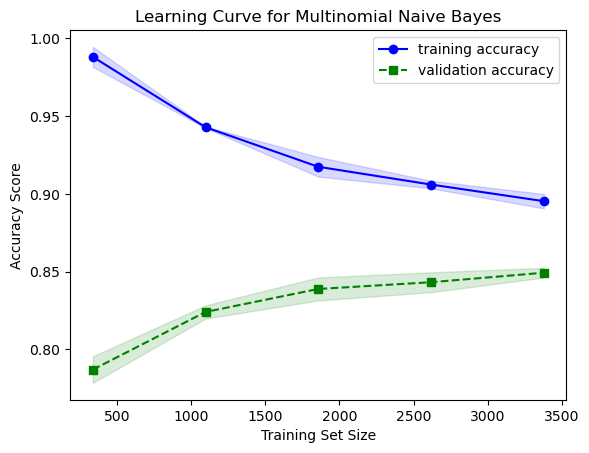

In [375]:
mnblearn(X_train1,y_train1,X_val1,y_val1)

bow

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'var_smoothing': 1e-06}
0.8172844826076142
Accuracy:  0.7914691943127962
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       334
           1       0.73      0.88      0.80       299

    accuracy                           0.79       633
   macro avg       0.80      0.80      0.79       633
weighted avg       0.81      0.79      0.79       633

[learning_curve] Training set sizes: [ 337 1097 1857 2617 3378]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.0s finished


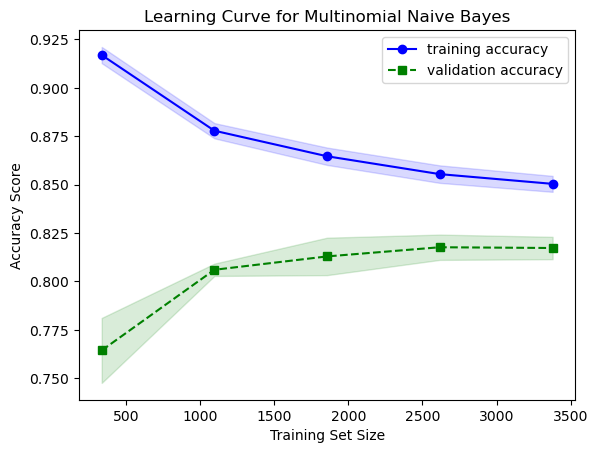

In [376]:
mnblearn(X_train2,y_train2,X_val2,y_val2)

DECISION TREE CLASSIFIER

In [377]:
def decision_grid_learn(X_train,y_train,X_val,y_val):
    dtree=DecisionTreeClassifier(random_state=0)
    param_grid = {'criterion':["gini","entropy"],'max_depth': [10, 50, 100, None]}
    grid_search = GridSearchCV(dtree, param_grid, cv=3,refit=True,n_jobs=-1,scoring='accuracy',verbose=1)
    grid_search.fit(X_train,y_train)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    print("Accuracy: ",accuracy_score(y_val,grid_search.predict(X_val)))
    print(classification_report(y_val,grid_search.predict(X_val)))
    train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1, verbose=1,shuffle=True)
    train_mean=np.mean(train_scores,axis=1)
    train_std=np.std(train_scores,axis=1)
    test_mean=np.mean(test_scores,axis=1)
    test_std=np.std(test_scores,axis=1)
    plt.plot(train_sizes,train_mean,color='blue',marker='o',label='training accuracy')
    plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
    plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',label='validation accuracy')
    plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')
    plt.title("Learning Curve for Decision Tree")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc='best')
    plt.show()

TF-IDF

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'criterion': 'entropy', 'max_depth': 50}
0.7979464524484335
Accuracy:  0.7946287519747235
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       334
           1       0.78      0.79      0.78       299

    accuracy                           0.79       633
   macro avg       0.79      0.79      0.79       633
weighted avg       0.79      0.79      0.79       633

[learning_curve] Training set sizes: [ 337 1097 1857 2617 3378]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   30.4s finished


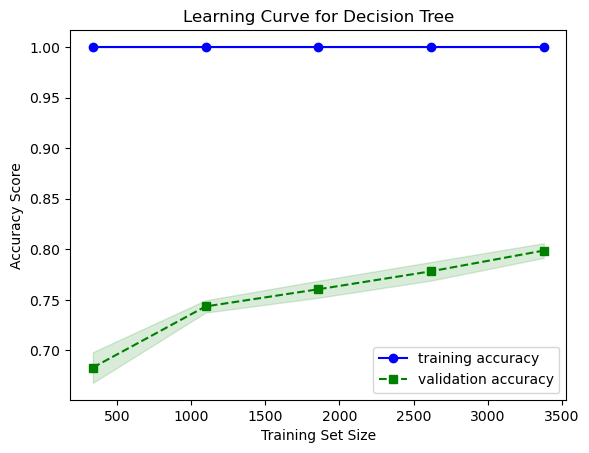

In [378]:
decision_grid_learn(X_train1,y_train1,X_val1,y_val1)

BoW

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'criterion': 'gini', 'max_depth': 10}
0.7953807149872185
Accuracy:  0.8120063191153238
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       334
           1       0.79      0.82      0.81       299

    accuracy                           0.81       633
   macro avg       0.81      0.81      0.81       633
weighted avg       0.81      0.81      0.81       633

[learning_curve] Training set sizes: [ 337 1097 1857 2617 3378]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.4s finished


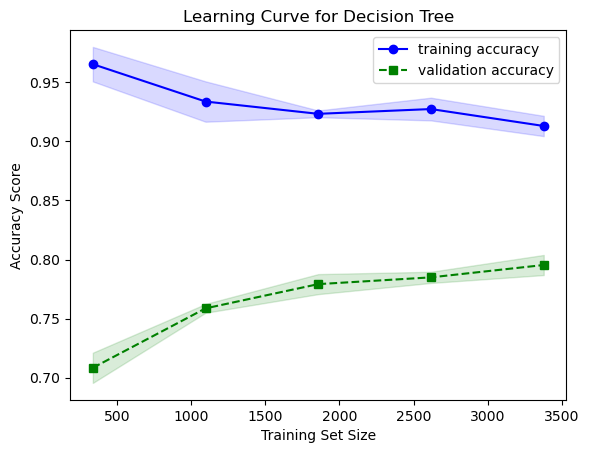

In [379]:
decision_grid_learn(X_train2,y_train2,X_val2,y_val2)